The core idea of DenseNet is that each layer in the network is directly connected to all previous layers, so that the input of each layer contains not only the output from the previous layer but also the output from all previous layers.  For an n-layer network, DenseNet contains a total of L(L+1)/2 connections.

DenseNet-121 has 121 layers, it includes 4 dense blocks and 3 transition layers.  In addition, at the end of the network, a global average pooling layer transformed the feature map into a one-dimensional vector.  Then using a lot of fully connected layers to classify it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Set the random seed for PyTorch and NumPy to ensure reproducibility of results
torch.manual_seed(42)
np.random.seed(42)

# Define the batch size and image size for the dataset
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

In [ ]:
# Define the classes and directories for the training and testing data
CLASSES = {
    0: "turtle",
    1: "penguin",
}
train_directory = "/content/drive/MyDrive/Colab Notebooks/Group Assignment/Penguins_vs_Turtles/archive/train/train"
test_directory = "/content/drive/MyDrive/Colab Notebooks/Group Assignment/Penguins_vs_Turtles/archive/valid/valid"

In [ ]:
# Create a list of file paths for the training and testing data, sorted in alphabetical order
train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
test_paths = sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))

def preprocess_annotations(path):
    df = pd.read_json(path)
    df["category_id"] = df["category_id"].replace(2, 0)
    return df

In [ ]:
# Use the preprocess_annotations function to read JSON files and preprocess the annotations
train_annotations = preprocess_annotations('/content/drive/MyDrive/Colab Notebooks/Group Assignment/Penguins_vs_Turtles/archive/train_annotations')
test_annotations = preprocess_annotations('/content/drive/MyDrive/Colab Notebooks/Group Assignment/Penguins_vs_Turtles/archive/valid_annotations')

# Display the first five rows of the train_annotations dataframe
train_annotations.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,0,"[225, 298, 198, 185]",36630,[],0
3,3,3,0,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [ ]:
# Resize the images to the specified size
resizer = transforms.Resize(IMAGE_SIZE)

In [ ]:
# Define the PenguinTurtleDataset class
class PenguinTurtleDataset(Dataset):
    def __init__(self, image_paths, annotations, transform=None):
        self.image_paths = image_paths
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path, label, and bounding box for the current index
        image_path = self.image_paths[idx]
        label = self.annotations["category_id"].iloc[idx]
        bbox = self.annotations["bbox"].iloc[idx]

        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Resize the image to the specified size
        image = resizer(image)

        # Apply the specified transform to the image
        if self.transform:
            image = self.transform(image)

        # Return the image, label, and bounding box as a tuple
        return image, label, torch.Tensor(bbox)

In [ ]:
# Resize the images to the specified size and apply random horizontal flip to the training data
train_transform = transforms.Compose([
    resizer,
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Resize the images to the specified size for the testing data
test_transform = transforms.Compose([
    resizer,
    transforms.ToTensor(),
])

In [ ]:
# Create the PenguinTurtleDataset objects for the training and testing data
train_dataset = PenguinTurtleDataset(train_paths, train_annotations, transform=train_transform)
test_dataset = PenguinTurtleDataset(test_paths, test_annotations, transform=test_transform)

# Create the DataLoader objects for the training and testing data
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class DetectionModel(nn.Module):
    def __init__(self):
        super(DetectionModel, self).__init__()
        self.densenet = densenet121(pretrained=True)

        # New layers for detection
        self.conv_layer = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)

        # Regression layers for bounding box prediction
        self.fc_regression = nn.Linear(256, 4)  # 4 output nodes for x_min, y_min, x_max, y_max
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        features = self.densenet.features(x)
        x = F.relu(self.conv_layer(features))
        x = F.avg_pool2d(x, kernel_size=3).view(x.size(0), -1)  # Global average pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Bounding box regression output
        regression_output = self.fc_regression(x)
        return regression_output


class ClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationModel, self).__init__()
        self.densenet = densenet121(pretrained=True)
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        features = self.densenet(x)
        output = self.fc(features)
        return output



In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models and move to device
model_classification = ClassificationModel(num_classes=2).to(device)
model_detection = DetectionModel().to(device)

# Define loss functions and optimizers
criterion_classification = nn.CrossEntropyLoss()
criterion_detection = nn.SmoothL1Loss()
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.00001)
optimizer_detection = optim.Adam(model_detection.parameters(), lr=0.00001)

# Train models
num_epochs = 30
best_acc = 0.0
best_loss = float('inf')
train_losses_classification = []
train_losses_detection = []
train_accs = []
for epoch in range(num_epochs):
    running_loss_classification = 0.0
    running_loss_detection = 0.0
    running_corrects = 0
    for images, labels, bboxes in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        # Train classification model
        optimizer_classification.zero_grad()
        outputs_classification = model_classification(images)
        loss_classification = criterion_classification(outputs_classification, labels)
        loss_classification.backward()
        optimizer_classification.step()

        # Train object detection model
        optimizer_detection.zero_grad()
        outputs_detection = model_detection(images)
        loss_detection = criterion_detection(outputs_detection, bboxes)
        loss_detection.backward()
        optimizer_detection.step()

        # Calculate loss and accuracy
        running_loss_classification += loss_classification.item() * images.size(0)
        running_loss_detection += loss_detection.item() * images.size(0)
        _, preds = torch.max(outputs_classification, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate loss and accuracy
    epoch_loss_classification = running_loss_classification / len(train_dataset)
    epoch_loss_detection = running_loss_detection / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Save best models
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model_classification.state_dict(), 'best_classification_model.pth')
    if epoch_loss_detection < best_loss:
        best_loss = epoch_loss_detection
        torch.save(model_detection.state_dict(), 'best_detection_model.pth')

    # Print loss and accuracy for each epoch
    print('Epoch [{}/{}], Classification Loss: {:.4f}, Detection Loss: {:.4f}, Classification Acc: {:.4f}'
          .format(epoch+1, num_epochs, epoch_loss_classification, epoch_loss_detection, epoch_acc))

    # Save losses
    train_losses_classification.append(epoch_loss_classification)
    train_losses_detection.append(epoch_loss_detection)
    train_accs.append(epoch_acc)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Classification Loss: 0.3897, Detection Loss: 238.4541, Classification Acc: 0.8080
Epoch [2/30], Classification Loss: 0.1221, Detection Loss: 237.8428, Classification Acc: 0.9740
Epoch [3/30], Classification Loss: 0.0802, Detection Loss: 235.2946, Classification Acc: 0.9860
Epoch [4/30], Classification Loss: 0.0646, Detection Loss: 226.4443, Classification Acc: 0.9840
Epoch [5/30], Classification Loss: 0.0409, Detection Loss: 204.6771, Classification Acc: 0.9960
Epoch [6/30], Classification Loss: 0.0265, Detection Loss: 163.1450, Classification Acc: 0.9980
Epoch [7/30], Classification Loss: 0.0425, Detection Loss: 126.0305, Classification Acc: 0.9920
Epoch [8/30], Classification Loss: 0.0229, Detection Loss: 112.5511, Classification Acc: 0.9960
Epoch [9/30], Classification Loss: 0.0157, Detection Loss: 106.2428, Classification Acc: 1.0000
Epoch [10/30], Classification Loss: 0.0125, Detection Loss: 103.3594, Classification Acc: 1.0000
Epoch [11/30], Classification Loss: 0.0

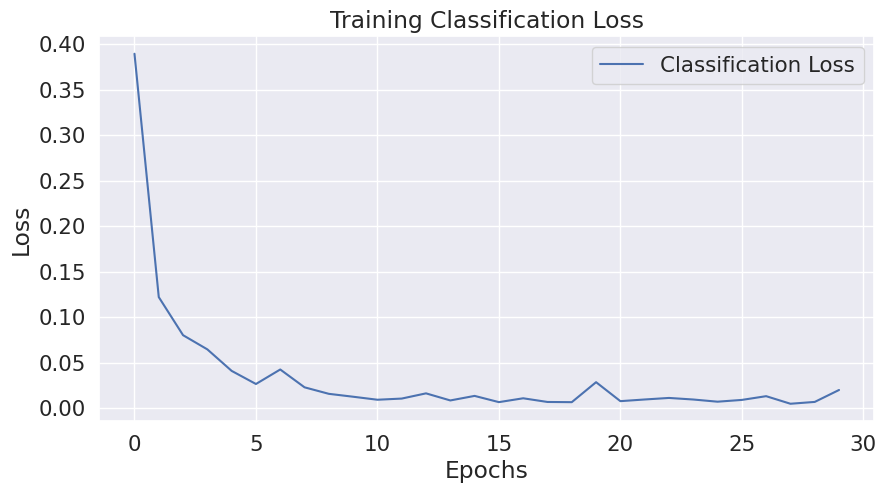

In [ ]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses_classification, label="Classification Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Classification Loss")
plt.legend()
plt.show()

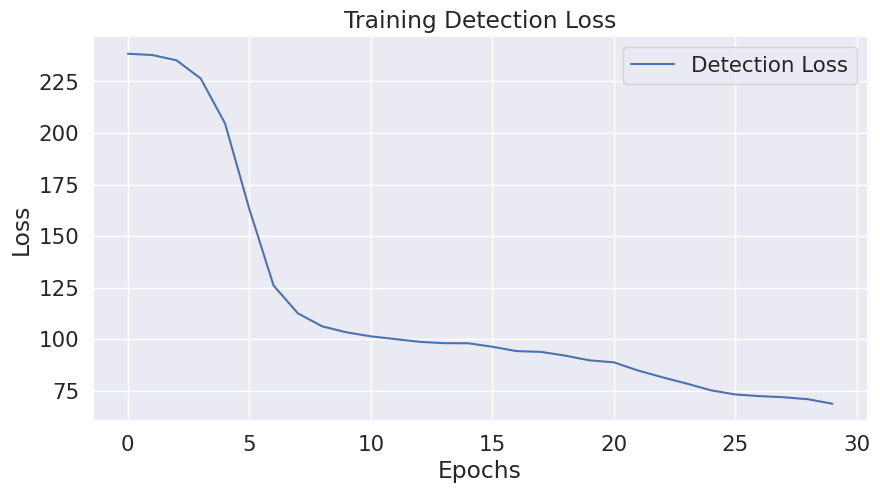

In [ ]:
# Plot Detection Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses_detection, label="Detection Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Detection Loss")
plt.legend()
plt.show()

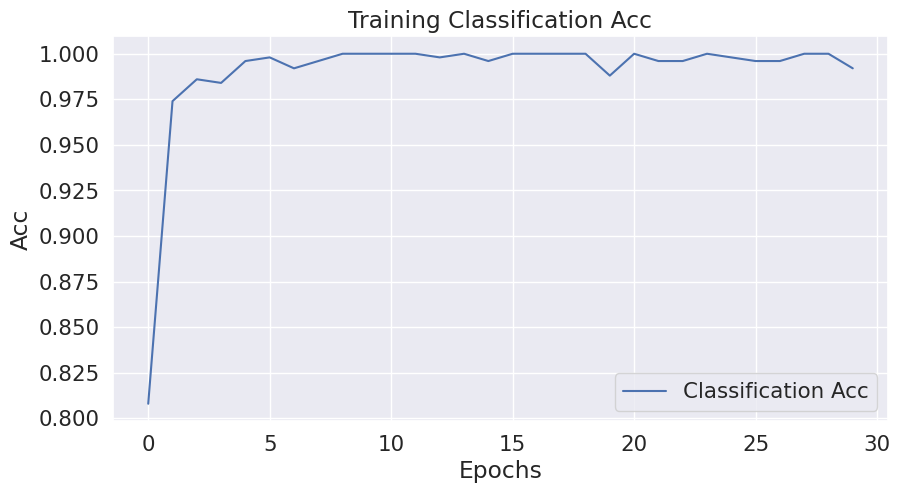

In [ ]:
# Plot Classification Acc
plt.figure(figsize=(10, 5))
train_accs_tensor = torch.tensor(train_accs)
plt.plot(range(num_epochs), train_accs_tensor.cpu(), label="Classification Acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Training Classification Acc")
plt.legend()
plt.show()

In [ ]:
def calculate_iou(box1, box2):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    area1 = w1 * h1
    area2 = w2 * h2
    xmin = max(x1 - w1 / 2, x2 - w2 / 2)
    ymin = max(y1 - h1 / 2, y2 - h2 / 2)
    xmax = min(x1 + w1 / 2, x2 + w2 / 2)
    ymax = min(y1 + h1 / 2, y2 + h2 / 2)
    inter_area = max(0, xmax - xmin) * max(0, ymax - ymin)
    iou = inter_area / (area1 + area2 - inter_area)
    return iou

In [ ]:
# Define the number of classes
num_classes = 2

# Define the loss functions
criterion_classification = nn.CrossEntropyLoss()
criterion_detection = nn.SmoothL1Loss()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained models
loaded_model_classification = ClassificationModel(num_classes=2).to(device)
loaded_model_detection = DetectionModel().to(device)
loaded_model_classification.load_state_dict(torch.load('best_classification_model.pth'))
loaded_model_detection.load_state_dict(torch.load('best_detection_model.pth'))

# Set the models to evaluation mode
loaded_model_classification.eval()
loaded_model_detection.eval()

# Initialize variables
running_loss_classification = 0.0
running_loss_detection = 0.0
running_corrects = 0
detection_distances = []
detection_ious = []
confusion_matrix = torch.zeros(num_classes, num_classes)

# Test the models on the test dataset
for images, labels, bboxes in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    bboxes = bboxes.to(device)

    # Forward pass
    with torch.no_grad():
        outputs_classification = loaded_model_classification(images)
        outputs_detection = loaded_model_detection(images)

    # Calculate loss and accuracy
    loss_classification = criterion_classification(outputs_classification, labels)
    loss_detection = criterion_detection(outputs_detection, bboxes)
    running_loss_classification += loss_classification.item() * images.size(0)
    running_loss_detection += loss_detection.item() * images.size(0)
    _, preds = torch.max(outputs_classification, 1)
    running_corrects += torch.sum(preds == labels.data)

    # Calculate detection performance
    for i in range(images.size(0)):
        detection_distance = torch.norm(outputs_detection[i][:2] - bboxes[i][:2])
        detection_distances.append(detection_distance.item())
        detection_iou = calculate_iou(outputs_detection[i], bboxes[i])
        detection_ious.append(detection_iou.item())

    # Calculate classification performance
    for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

# Calculate loss and accuracy
test_loss_classification = running_loss_classification / len(test_dataset)
test_loss_detection = running_loss_detection / len(test_dataset)
test_acc = running_corrects.double() / len(test_dataset)

# Calculate detection performance metrics
detection_mean_distance = torch.tensor(detection_distances).mean().item()
detection_std_distance = torch.tensor(detection_distances).std().item()
detection_mean_iou = torch.tensor(detection_ious).mean().item()
detection_std_iou = torch.tensor(detection_ious).std().item()

# Calculate classification performance metrics
confusion_matrix = confusion_matrix.numpy()
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = np.mean(2 * precision * recall / (precision + recall))

# Print the test results
print('Test Classification Loss: {:.4f}, Detection Loss: {:.4f}, Classification Acc: {:.4f}'
      .format(test_loss_classification, test_loss_detection, test_acc))
print('Detection Mean Distance: {:.4f}, Detection Std Distance: {:.4f}, Detection Mean IoU: {:.4f}, Detection Std IoU: {:.4f}'
      .format(detection_mean_distance, detection_std_distance, detection_mean_iou, detection_std_iou))
print('Confusion Matrix:\n', confusion_matrix)
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'
      .format(accuracy, np.mean(precision), np.mean(recall), f1_score))

Test Classification Loss: 0.0416, Detection Loss: 66.6789, Classification Acc: 0.9861
Detection Mean Distance: 91.3106, Detection Std Distance: 48.1400, Detection Mean IoU: 0.4350, Detection Std IoU: 0.1853
Confusion Matrix:
 [[36.  0.]
 [ 1. 35.]]
Accuracy: 0.9861, Precision: 0.9865, Recall: 0.9861, F1 Score: 0.9861


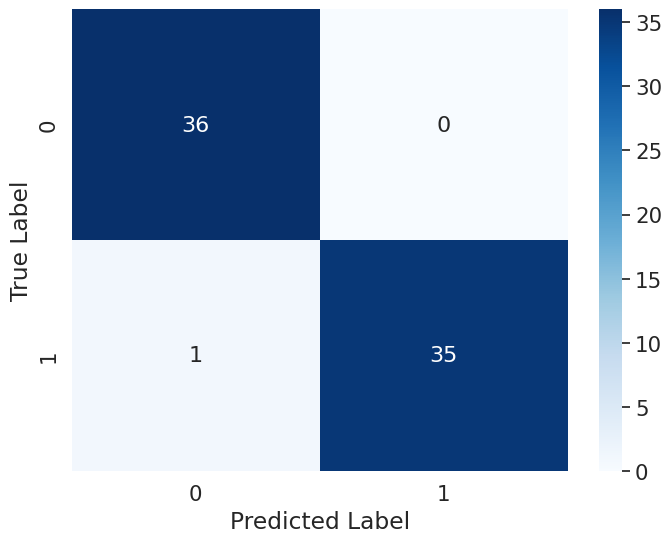

In [ ]:
import seaborn as sns

# Set figure size and font scale
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

# Set the x and y labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()